In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # or the full path to the "project" directory
import numpy as np
import gpbr

In [2]:
from gpbr.direct.common.boundary import Point3D
def matf1(X, t: float) -> float:
    return np.zeros_like(X[0])

def matf2(X, t: float) -> float:
    return np.ones_like(X[0]) ## TODO: Add time dependence

def r2(theta, phi):
     return np.ones_like(theta)*0.8
def dr2_dtheta(theta, phi):
     return np.zeros_like(phi)
def dr2_dphi(theta, phi):
     return np.zeros_like(theta)

# # Define the radial function r(theta, phi)
def r1(theta, phi):
    return 0.45*(1 + 0.5 * np.sin(2 * theta) * np.cos(phi))  # Example radial function


# def r1(theta, phi):
#     return 0.2*(0.6 + np.sqrt(4.25+2*np.cos(3*theta)))

# def r1(theta, phi):
#     return 0.5*np.sqrt(0.8+0.2*(np.cos(2*phi)-1)*(np.cos(4*theta)-1))


# def r1(theta, phi):
#     return np.ones_like(theta)*0.5

# # Define the derivatives of r with respect to theta and phi
# def dr1_dtheta(theta, phi):
#     return 0.5 * 2 * np.cos(2 * theta) * np.cos(phi)

# def dr1_dphi(theta, phi):
#     return -0.5 * np.sin(2 * theta) * np.sin(phi)

In [3]:
from gpbr.direct.heat_equation.common import MFSConfig, Dimension, MFSConfig3D

T = 1 # final time
N = 7 # N+1=10 time points

# Collocation 64 points
m1 = 8
m2 = 8
M_coll = m1 * m2 # number of collocation points
# Source
m1_source = 4
m2_source = 8
M_source = 2 * m1_source * m2_source


# # Collocation 256 points
# m1 = 16
# m2 = 16
# M_coll = m1 * m2 # number of collocation points
# # Source
# m1_source = 8
# m2_source = 16
# M_source = 2 * m1_source * m2_source


ETA1 = 0.5
ETA2 = 2.0
config = MFSConfig3D(
    N=N,
    n_coll=M_coll,
    n_source=M_source,
    T=T,
    eta1=ETA1,
    eta2=ETA2,
    f1=matf1,
    f2=matf2,
    n_coll_theta=m1,
    n_coll_phi=m2,
    n_source_theta=m1_source,
    n_source_phi=m2_source
)


In [4]:
from gpbr.direct.heat_equation.helpers import precalculate_mfs_data
mfs_data = precalculate_mfs_data(config)

In [5]:
from gpbr.direct.common.boundary import StarlikeSurface
Gamma2 = StarlikeSurface.from_radial_with_derivative(mfs_data.collocation, r2, dr2_dphi, dr2_dtheta)
Gamma2_source = StarlikeSurface.from_radial(mfs_data.source_collocation, r2)
Gamma2_rvals = r2(mfs_data.collocation.theta_grid, mfs_data.collocation.phi_grid)

In [6]:
%matplotlib widget
import matplotlib.pyplot as plt
def plot_poitns(Gamma: StarlikeSurface):
    fig_plot, ax_plot = plt.subplots(subplot_kw={"projection": "3d"})

    xx, yy, zz = Gamma.mesh_np
    nxx, nyy, nzz = Gamma.normals_mesh_np
    ax_plot.plot(xx.ravel(), yy.ravel(), zz.ravel(), 'bo')
    ax_plot.quiver(xx.ravel(), yy.ravel(), zz.ravel(), nxx.ravel(), nyy.ravel(), nzz.ravel(), color='r', length=0.5)

    # Set axis limits
    ax_plot.set_xlim3d([-3, 3])
    ax_plot.set_ylim3d([-3, 3])
    ax_plot.set_zlim3d([-3, 3])

    # Set axis labels
    ax_plot.set_xlabel('X axis')
    ax_plot.set_ylabel('Y axis')
    ax_plot.set_zlabel('Z axis')

    # Add grid and legend
    ax_plot.grid(True)
    ax_plot.legend()

    # Show the plot
    plt.show()

/var/folders/yp/sztpn13x2vq42vlgbb1zx8b80000gn/T/ipykernel_42410/160596819.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_plot.legend()


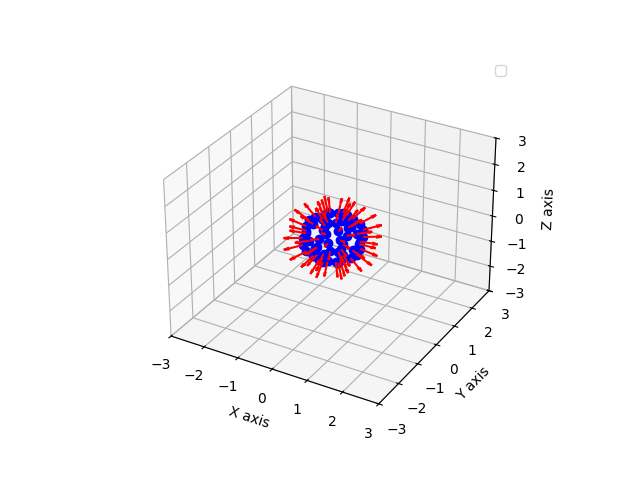

In [7]:
plot_poitns(Gamma2)

In [8]:
from gpbr.direct.common.source import SourcePoints2D, SourcePoints3D
from gpbr.direct.heat_equation.fundamental_sequence import fundamental_sequence_2d, FundamentalSequence, fundamental_sequence_3d, matfundamental_sequence_3d
from gpbr.direct.heat_equation.helpers import dbu_3d, form_fs_matrix, form_fs_vector_2d, form_fs_vector_3d, matdbu_3d, matdbu_3d_all, matform_fs_vector_3d
from gpbr.direct.heat_equation.helpers import dbu_2d

from gpbr.direct.heat_equation.fundamental_sequence import FundamentalSequenceCoefs
from numpy.linalg import lstsq

def eval_for_g1(
        Gamma2: StarlikeSurface,
        Gamma2_source: StarlikeSurface,
        f1, f2,
        mfs_data,
        r1_func
    ):
    Gamma1 = StarlikeSurface.from_radial(mfs_data.collocation, r1_func)
    Gamma1_source = StarlikeSurface.from_radial(mfs_data.source_collocation, r1_func)
    src_cnt = Gamma1_source.collocation.n_phi * Gamma1_source.collocation.n_theta
    src_cnt+= Gamma2_source.collocation.n_phi * Gamma2_source.collocation.n_theta

    source_points = SourcePoints3D(src_cnt, mfs_data.eta1, mfs_data.eta2, Gamma1_source, Gamma2_source)


    fundamental_sequence_gamma1 = matfundamental_sequence_3d(Gamma1, source_points, mfs_data)
    fundamental_sequence_gamma2 = matfundamental_sequence_3d(Gamma2, source_points, mfs_data)
    PHI_MAT = form_fs_matrix(fundamental_sequence_gamma1, fundamental_sequence_gamma2)


    alpha_coeeff = np.empty((mfs_data.N+1, mfs_data.M), dtype=np.float64)
    alpha_coeeff[:] = np.nan
    fs_coefs = FundamentalSequenceCoefs(alpha_coeeff)
    for n in range(0, mfs_data.N+1):
        F = matform_fs_vector_3d(n,
                            fundamental_sequence_gamma1,
                            fundamental_sequence_gamma2,
                            Gamma1,
                            Gamma2,
                            fs_coefs,
                            f1, f2, mfs_data)
        try:
            alpha_n = lstsq(PHI_MAT, F)[0]
        except np.linalg.LinAlgError:
            print(f"Failed to solve the linear system for function {r1_func}")
            return None
        fs_coefs.alpha[n] = alpha_n.T

    return matdbu_3d_all(Gamma2.mesh_np, Gamma2.normals_mesh_np, mfs_data.N, source_points, fs_coefs, mfs_data).reshape((mfs_data.N+1, mfs_data.M))


In [9]:
exact_heat_flux = eval_for_g1(Gamma2, Gamma2_source, matf1, matf2, mfs_data, r1)

In [10]:
from gpbr.tools.noise import noise
# heat_flux = noise(exact_heat_flux, 0.03, seed=373888273)
heat_flux = exact_heat_flux

In [11]:
import matplotlib.pyplot as plt

def plot_surface(G1):
    fig_plot = plt.figure()
    ax_plot = fig_plot.add_subplot(111, projection='3d')

    rvals  = G1.rf(G1.collocation.theta_grid, G1.collocation.phi_grid) # We use numpy funtions, so we can do that way
    xx = rvals * np.sin(G1.collocation.theta_grid) * np.cos(G1.collocation.phi_grid)
    yy = rvals * np.sin(G1.collocation.theta_grid) * np.sin(G1.collocation.phi_grid)
    zz = rvals * np.cos(G1.collocation.theta_grid)

    # Plot the surface
    surf = ax_plot.plot_surface(xx, yy, zz, cmap='viridis')

    # Set axis labels
    ax_plot.set_xlabel('X axis')
    ax_plot.set_ylabel('Y axis')
    ax_plot.set_zlabel('Z axis')

    # Add grid
    ax_plot.grid(True)

    # Show the plot
    plt.show()
    # plt.close()


In [12]:
import matplotlib.pyplot as plt

def plot_two_surfaces(G1, G2):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Surface 2 (outer) - Plot as semi-transparent 
    rvals2 = G2.rf(G2.collocation.theta_grid, G2.collocation.phi_grid)
    x2 = rvals2 * np.sin(G2.collocation.theta_grid) * np.cos(G2.collocation.phi_grid)
    y2 = rvals2 * np.sin(G2.collocation.theta_grid) * np.sin(G2.collocation.phi_grid)
    z2 = rvals2 * np.cos(G2.collocation.theta_grid)
    surf2 = ax.plot_surface(x2, y2, z2, color='skyblue', alpha=0.3, 
                           edgecolor='navy', linewidth=0.25)

    # Surface 1 (inner) - Make more visible with solid color and prominent edges
    rvals1 = G1.rf(G1.collocation.theta_grid, G1.collocation.phi_grid)
    x1 = rvals1 * np.sin(G1.collocation.theta_grid) * np.cos(G1.collocation.phi_grid)
    y1 = rvals1 * np.sin(G1.collocation.theta_grid) * np.sin(G1.collocation.phi_grid)
    z1 = rvals1 * np.cos(G1.collocation.theta_grid)
    surf1 = ax.plot_surface(x1, y1, z1, color='crimson', alpha=0.8, 
                           edgecolor='black', linewidth=0.5)
    
    # Add a wireframe to the outer surface for better structure visibility
    ax.plot_wireframe(x2, y2, z2, color='blue', alpha=0.2, linewidth=0.2)
    
    # Create a custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='crimson', lw=4, label='Inner Surface'),
        Line2D([0], [0], color='skyblue', lw=4, label='Outer Surface')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    # Set axis labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    # Start with a good view angle
    ax.view_init(elev=30, azim=45)

    # Add a title
    ax.set_title('Nested Surfaces Visualization', fontsize=14)
    
    plt.tight_layout()
    plt.show()

    return fig, ax  # Return fig and ax for potential further manipulation

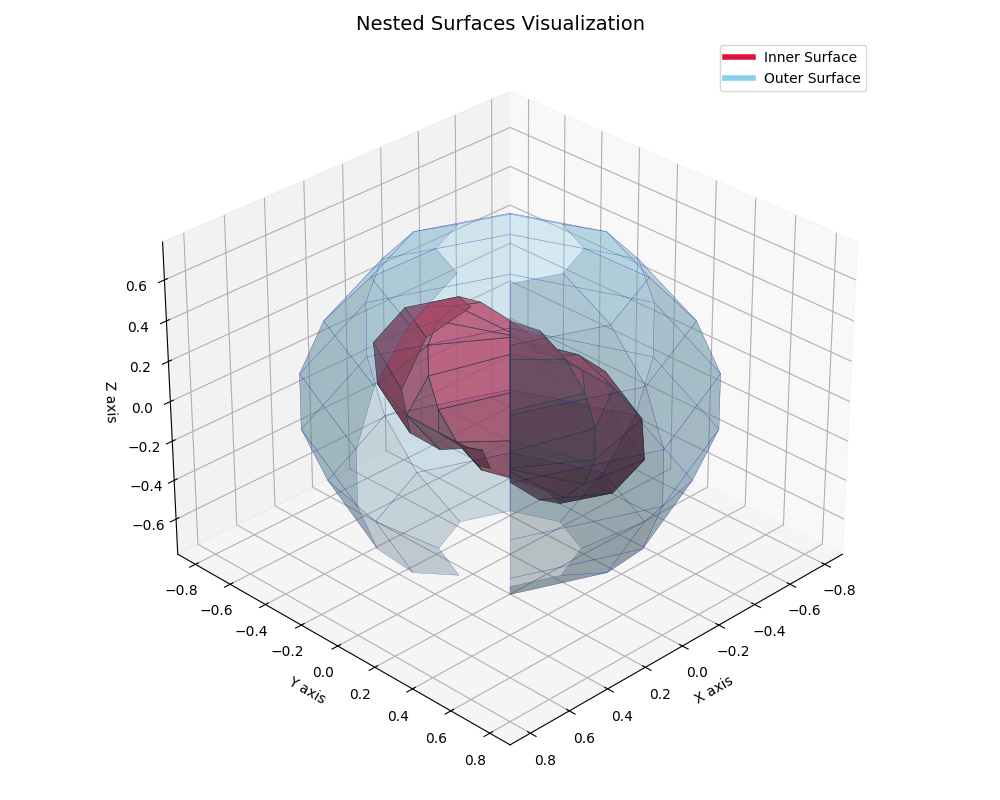

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': 'Nested Surfaces Visualization'}, xlabel='X axis', ylabel='Y axis', zlabel='Z axis'>)

In [13]:
G1_plot = StarlikeSurface.from_radial(mfs_data.collocation, r1)
plot_two_surfaces(G1_plot, Gamma2)

## Fitness calculation

In [14]:
from scipy import integrate

# def calc_l2_norm(theta_coll, phi_coll, t_coll, exact, approx, approxfunc=None):
#     vals_reshapred = ((exact-approx)**2).reshape(-1, len(phi_coll), len(theta_coll))

#     # First integrate along the theta direction (axis=2)
#     theta_int = np.trapezoid(vals_reshapred, x=theta_coll, axis=2)

#     # Then integrate the result along phi (axis=1), yielding one value per time slice
#     time_vals = np.trapezoid(theta_int, x=phi_coll, axis=1)

#     # Finally integrate in time using mfs_data.tn as the grid
#     return np.trapezoid(time_vals, x=t_coll)



# def calc_l2_norm(theta_coll, phi_coll, t_coll, exact, approx, approxfunc=None):
#     diff_squared = (exact - approx) ** 2
#     diff_squared = diff_squared.reshape(-1, len(phi_coll), len(theta_coll))
#     # diff_squared = diff_squared.reshape(-1, len(phi_coll), len(theta_coll))
#     mult = (0.8)**2* np.sin(mfs_data.collocation.theta)
#     mult = np.tile(mult, (len(theta_coll), 1))
#     integral_shape = []
#     for ni in range(0, N+1):
#         integral_theta = integrate.trapezoid(diff_squared[ni]*mult, theta_coll)
#         integral_shape.append(integrate.trapezoid(integral_theta, phi_coll))
    
#     # return integrate.trapezoid(integral_shape, t_coll)

#     if approxfunc is None:
#         return integrate.trapezoid(integral_shape, t_coll)
    
#     Theta, Phi = np.meshgrid(theta_coll, phi_coll)
#     approx_vals = approxfunc(Theta, Phi)
#     if np.ndim(approx_vals) == 0:
#         approx_vals = np.full(Theta.shape, approx_vals)
#     return integrate.trapezoid(integral_shape, t_coll) + integrate.trapezoid(integrate.trapezoid(approx_vals**2, theta_coll, axis=0), phi_coll, axis=0)*1e-4

    # return  integrate.trapezoid(integrate.trapezoid(approxfunc(Theta, Phi)**2, theta_coll, axis=0), phi_coll, axis=0)
    # return integrate.trapezoid(integral_shape, t_coll) + integrate.dblquad(lambda theta,phi: approxfunc(theta,phi)**2, 0, np.pi, 0, 2*np.pi)[0]*1e-4

def calc_l2_norm(theta_coll, phi_coll, t_coll, exact, approx, approxfunc=None):
    diff_squared = (exact - approx) ** 2
    return np.linalg.norm(diff_squared)
    thetas = np.linspace(0, np.pi, 512)
    phis = np.linspace(0, 2*np.pi, 512)
    Theta, Phi = np.meshgrid(thetas, phis)
    approx_vals = approxfunc(Theta, Phi)
    if np.ndim(approx_vals) == 0:
        approx_vals = np.full(Theta.shape, approx_vals)
    # return np.linalg.norm((exact - approx)**2)
    return np.linalg.norm((exact - approx))**2 + + integrate.trapezoid(integrate.trapezoid(approx_vals**2, thetas, axis=0), phis, axis=0)*1e-4

In [15]:
def feasable(ext_boundary, rfunc, rvals):
    thetas = np.linspace(0, 2*np.pi, 100)

    rvals_start = rfunc(thetas, np.zeros_like(thetas))
    rvals_stop = rfunc(thetas, 2*np.pi*np.ones_like(thetas))

    if not np.allclose(rvals_start, rvals_stop):
        return False
    
    if not np.isfinite(rvals).all():
        return False

    if np.any(np.less_equal(rvals, 0.0)):
        return False

    if np.any(np.greater_equal(rvals, ext_boundary)):
        return False

    return True

def feasable_fine(ext_boundary, rfunc, rvals):
    thetas = np.linspace(0, 2*np.pi, 100)

    rvals_start = rfunc(thetas,np.zeros_like(thetas))
    rvals_stop = rfunc(thetas, 2*np.pi*np.ones_like(thetas))

    if not np.allclose(rvals_start, rvals_stop):
        return 20.0
    
    if not np.isfinite(rvals).all():
        return 1000.0

    if np.any(np.less_equal(rvals, 0.0)):
        return 30.0

    if np.any(np.greater_equal(rvals, ext_boundary)):
        return 500.0
    
    return 0.0

In [16]:
def evaluate(mfsd, tlb, ind):
    ind_compile = tlb.compile(expr=ind)
    ind_values = ind_compile(mfsd.collocation.theta_grid, mfsd.collocation.phi_grid)

    if not tlb.feasable(ind_compile, ind_values):
        return (1000, )

    g2_approx = tlb.calc_normals(ind_compile)
    if g2_approx is None:
        return (1000, )
    return (tlb.norm(approx=g2_approx, approxfunc=ind_compile), )

## Primitive set

In [17]:
import random
from deap import gp
from gpbr.gp.funcs import sqrtabs

pset = gp.PrimitiveSet("main", 2)
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(np.cos, 1)
pset.addPrimitive(np.sin, 1)
pset.addPrimitive(sqrtabs, 1)
pset.addEphemeralConstant('rand', (np.random.rand, 1)[0])

pset.renameArguments(ARG0="theta")
pset.renameArguments(ARG1="phi")

### Individual representation

In [18]:
import random
from deap import creator, base, tools, algorithms
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

### Toolbox compiling

In [19]:
toolbox = base.Toolbox()
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=5, max_=10)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)

In [20]:
toolbox.register('feasable', feasable, Gamma2_rvals)
toolbox.register('feasable_fine', feasable_fine, Gamma2_rvals)
toolbox.register('calc_normals', eval_for_g1, Gamma2, Gamma2_source, matf1, matf2, mfs_data)
toolbox.register('norm', calc_l2_norm, theta_coll=mfs_data.collocation.theta, phi_coll=mfs_data.collocation.phi, t_coll=mfs_data.tn, exact=heat_flux)
toolbox.register('evaluate', evaluate, mfs_data, toolbox)

## Selection

In [21]:
toolbox.register("select", tools.selTournament, tournsize=3)

### Operators

In [22]:
def random_operator(options):
    return random.choice(options)

In [23]:
from gpbr.gp.operators import cxLinearCombination
toolbox.register("mate_onepoint", gp.cxOnePoint)
toolbox.register("mate_lincomb", cxLinearCombination, pset=pset)
toolbox.register("mate_leaf_based", gp.cxOnePointLeafBiased, termpb=0.35)
mate_operators = [toolbox.mate_lincomb, toolbox.mate_onepoint, toolbox.mate_leaf_based]

toolbox.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=3)
toolbox.register("mutate_uniform", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("mutate_node_replacement", gp.mutNodeReplacement, pset=pset)
toolbox.register("mutate_ephemeral", gp.mutEphemeral, mode="one")
toolbox.register("mutate_insert", gp.mutInsert, pset=pset)
toolbox.register("mutate_shrink", gp.mutShrink)
mutate_operators = [toolbox.mutate_uniform, toolbox.mutate_ephemeral]


toolbox.register("mate", random.choice(mate_operators))
toolbox.register("mutate", random.choice(mutate_operators))

## Bloat control

In [24]:
import operator

# toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))
# toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [25]:
pop = toolbox.population(n=500)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

In [26]:
# pop, log = algorithms.eaSimple(pop, toolbox, 0.6, 0.2, 50, stats=mstats,
#                             halloffame=hof, verbose=True)
# pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats,
#                             halloffame=hof, verbose=True)

# MU, LAMBDA = 100, 200
# pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
#                                             cxpb=0.7, mutpb=0.3, ngen=40, 
#                                             stats=mstats, halloffame=hof)

## Similar to R-model
# MU, LAMBDA = 300, 200
# pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
#                                             cxpb=0.7, mutpb=0.3, ngen=40, 
#                                             stats=mstats, halloffame=hof)

MU, LAMBDA = 100, 200
# MU, LAMBDA = 200, 400
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=MU, lambda_=LAMBDA,
                                            cxpb=0.7, mutpb=0.3, ngen=300, 
                                            stats=mstats, halloffame=hof)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min   	nevals	std    	avg   	gen	max	min	nevals	std    
0  	500   	1263.91	0  	80565.9	26.437	500   	4031.97	37.924	0  	274	6  	500   	35.8526
1  	200   	899.546	1  	1000   	26.3842	200   	265.822	38.43 	1  	205	4  	200   	38.0106
2  	200   	773.86 	2  	1000   	26.3842	200   	357.796	36.95 	2  	205	4  	200   	44.6061
3  	200   	487.25 	3  	1000   	25.7488	200   	439.302	21.04 	3  	201	2  	200   	24.5047
4  	200   	133.123	4  	1000   	22.5906	200   	223.418	14.46 	4  	47 	2  	200   	7.56891
5  	200   	49.4088	5  	504.438	22.5906	200   	52.0286	13.82 	5  	34 	2  	200   	6.50135
6  	200   	37.1252	6  	97.4527	23.999 	200   	10.4095	12.81 	6  	34 	2  	200   	7.3698 
7  	200   	33.7679	7  	106.208	23.2779	200   	10.205 	12.48 	7  	34 	2  	200   	7.89

KeyboardInterrupt: 

In [27]:
print(hof[0])

sin(sin(cos(cos(sin(multiply(sin(sin(cos(theta))), sin(cos(cos(sin(multiply(sin(sin(sin(cos(theta)))), cos(cos(sin(multiply(0.3894443962005776, sin(cos(theta)))))))))))))))))


In [28]:
for ind in pop:
    print(ind, ind.fitness.values)

sin(sin(cos(cos(sin(multiply(sin(sin(cos(theta))), sin(cos(cos(sin(multiply(sin(sin(sin(cos(theta)))), cos(cos(sin(multiply(0.34817848700948273, sin(cos(theta))))))))))))))))) (np.float64(21.267944633496754),)
sin(sin(cos(cos(sin(multiply(sin(sin(cos(theta))), sin(cos(cos(sin(multiply(sin(sin(sin(cos(theta)))), cos(cos(sin(multiply(0.3867911243943374, sin(cos(theta))))))))))))))))) (np.float64(21.2678667608596),)
sin(sin(cos(cos(sin(multiply(sin(sin(cos(theta))), sin(cos(cos(sin(multiply(sin(sin(sin(cos(theta)))), cos(cos(sin(multiply(0.34817848700948273, sin(cos(theta))))))))))))))))) (np.float64(21.267944633496754),)
sin(sin(cos(cos(sin(multiply(sin(sin(cos(theta))), sin(cos(cos(sin(multiply(sin(sin(sin(cos(theta)))), cos(cos(sin(multiply(0.3282396608063707, sin(cos(theta))))))))))))))))) (np.float64(21.268029088937467),)
sin(sin(cos(cos(sin(multiply(sin(sin(cos(theta))), sin(cos(cos(sin(multiply(sin(sin(sin(cos(theta)))), cos(cos(sin(multiply(0.4215648378782526, sin(cos(theta)))))))

In [29]:
def plot_approx_and_exact(rexact, rapprox):
    """
    Plot exact and approximated solutions with error visualization.
    
    Parameters:
    - exact_solution: StarlikeSurface object representing the exact solution
    - approx_solution: StarlikeSurface object representing the approximated solution
    """
    # Create a figure with three subplots - side, top, error
    fig = plt.figure(figsize=(18, 6))
    
    # First subplot: Side-by-side comparison
    ax1 = fig.add_subplot(131, projection='3d')

    # Extract data for exact solution
    thetas = np.linspace(0, np.pi, 512)
    phis = np.linspace(0, 2 * np.pi, 512)

    theta_grid, phi_grid = np.meshgrid(thetas, phis)
    # theta_grid = np.linspace(0, np.pi, 512)
    # phi_grid = np.linspace(0, 2 * np.pi, 512)
    
    # Exact solution (left half)
    rvals_exact = rexact(theta_grid, phi_grid)
    x_exact = rvals_exact * np.sin(theta_grid) * np.cos(phi_grid)
    y_exact = rvals_exact * np.sin(theta_grid) * np.sin(phi_grid)
    z_exact = rvals_exact * np.cos(theta_grid)
    
    # Approximate solution (right half)
    rvals_approx = rapprox(theta_grid, phi_grid)
    x_approx = rvals_approx * np.sin(theta_grid) * np.cos(phi_grid)
    y_approx = rvals_approx * np.sin(theta_grid) * np.sin(phi_grid)
    z_approx = rvals_approx * np.cos(theta_grid)
    
    # Compute the difference/error between surfaces
    diff = np.abs(rvals_exact - rvals_approx)
    max_diff = np.max(diff)
    
    # Plot exact solution
    surf_exact = ax1.plot_surface(x_exact, y_exact, z_exact, 
                                 color='green', alpha=0.7,
                                 label='Exact')
    
    # Plot approximate solution
    surf_approx = ax1.plot_surface(x_approx, y_approx, z_approx, 
                                  color='red', alpha=0.3,
                                  label='Approximation')
    
    ax1.set_title('Exact vs Approximate Solutions')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    # Second subplot: Overlay with color-mapped error
    ax2 = fig.add_subplot(132, projection='3d')
    
    # Plot exact solution as wireframe for reference
    ax2.plot_wireframe(x_exact, y_exact, z_exact, 
                      color='black', alpha=0.3, linewidth=0.5)
    
    # Plot approximate solution with error-based colormapping
    norm = plt.Normalize(0, max_diff)
    surf_error = ax2.plot_surface(x_approx, y_approx, z_approx, 
                                 facecolors=plt.cm.jet(norm(diff)),
                                 alpha=0.8)
    
    # Add a colorbar
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet), 
                       ax=ax2, shrink=0.6, aspect=10)
    cbar.set_label('Absolute Error')
    
    ax2.set_title('Error Distribution')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    # Third subplot: 2D Error Heatmap (unwrapped view)
    ax3 = fig.add_subplot(133)
    
    # Create a 2D heatmap of the error
    im = ax3.pcolormesh(phi_grid, theta_grid, diff, cmap='jet', shading='auto')
    cbar2 = fig.colorbar(im, ax=ax3)
    cbar2.set_label('Absolute Error')
    
    ax3.set_title('Unwrapped Error Distribution')
    ax3.set_xlabel('φ (Phi)')
    ax3.set_ylabel('θ (Theta)')
    
    # Set consistent view angles
    ax1.view_init(elev=30, azim=45)
    ax2.view_init(elev=30, azim=45)
    
    # Create a custom legend for the first subplot
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='green', lw=4, label='Exact Solution'),
        Line2D([0], [0], color='red', lw=4, label='Approximation')
    ]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    return fig, (ax1, ax2, ax3)

(<Figure size 1800x600 with 5 Axes>,
 (<Axes3D: title={'center': 'Exact vs Approximate Solutions'}, xlabel='X', ylabel='Y', zlabel='Z'>,
  <Axes3D: title={'center': 'Error Distribution'}, xlabel='X', ylabel='Y', zlabel='Z'>,
  <Axes: title={'center': 'Unwrapped Error Distribution'}, xlabel='φ (Phi)', ylabel='θ (Theta)'>))

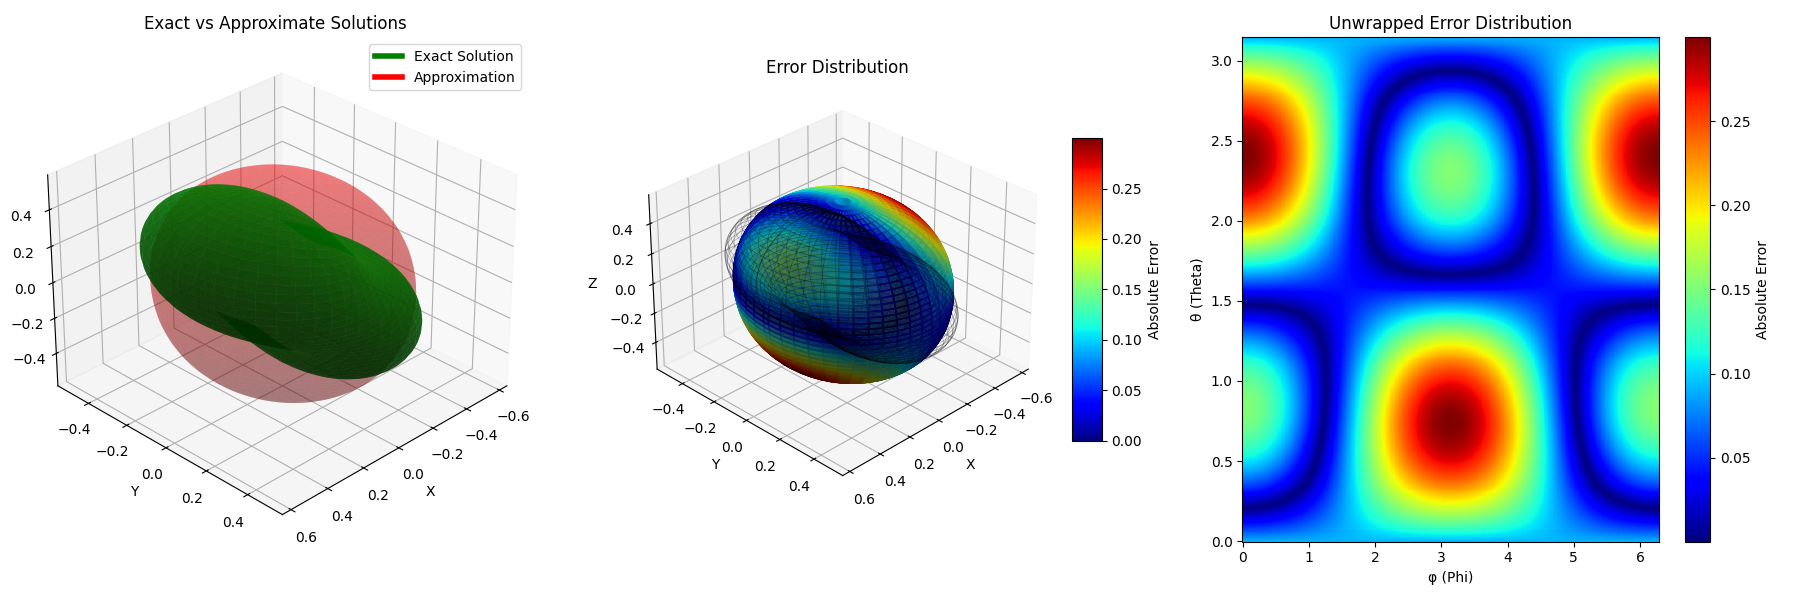

In [30]:

# G1_plot_exact = StarlikeSurface.from_radial(mfs_data.collocation, r1)
# G1_plot_approx = StarlikeSurface.from_radial(mfs_data.collocation, toolbox.compile(expr=hof[0]))
# plot_approx_and_exact(G1_plot_exact, G1_plot_approx)
plot_approx_and_exact(r1, toolbox.compile(expr=hof[0]))
# plot_approx_and_exact(r1, toolbox.compile(expr=ind))

In [ ]:
G1_test = StarlikeSurface.from_radial(mfs_data.collocation, toolbox.compile(expr=hof[0]))
toolbox.plot(G1_test)

AttributeError: 'Toolbox' object has no attribute 'plot'

In [ ]:
# rapprox = toolbox.compile(expr=ind)
rapprox = toolbox.compile(expr=hof[0])
enum = integrate.dblquad(lambda theta, phi: (r1(theta, phi) - rapprox(theta, phi)) ** 2, 0, np.pi, 0, 2*np.pi)
den = integrate.dblquad(lambda theta, phi: (r1(theta, phi)) ** 2, 0, np.pi, 0, 2*np.pi)
print("L2 norm: ", np.sqrt(enum[0]/den[0]))

/Users/armarche/.pyenv/versions/3.12.6/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


L2 norm:  0.206472367296631
